In [1]:
import numpy as np
import xarray as xr
import math
import os
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from scipy.interpolate import griddata
from tqdm import tqdm

%matplotlib inline

In [70]:
plt.rcParams['font.size'] = 14

In [24]:
def mtime_to_datetime(mtime):
    """Convert from Matlab time to datetime.datetime
    """
    
    return datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)


def rotate_vel(u_in, v_in, theta=29):
    """Rotate velocities from map coordinates to grid coordinates
    """
    
    theta_rad = math.radians(theta)
    u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)
    v_out = -u_in * np.sin(theta_rad) + v_in * np.cos(theta_rad)
    
    return u_out, v_out


def boundingbox(data, time, lon, lat, lonlat, size=1):
    """Return a bounding box of coordinate, value pairs around a lonlat point
    """

    j, i = [gridref[var].sel(lats=lat, lons=lon, method='nearest').item() for var in ('jj', 'ii')]
    if -999 in [j, i]: return None, None
    jslc, islc = [slice(max(coord - size, 0), coord + size + 1) for coord in (j, i)]
    points = np.vstack([coord[jslc, islc].ravel() for coord in lonlat]).T
    values = data.isel(y=jslc, x=islc).interp(time_counter=time).values.ravel()
    
    return points, values

In [3]:
# Paths
paths = {
    'grid': '/home/bmoorema/MEOPAR/grid/',
    'results': '/scratch/bmoorema/Results/Currents/',
    'obs': '/home/bmoorema/project/SalishSea/obs/',
}

# Master files
coords = xr.open_dataset(paths['grid'] + 'coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset(paths['grid'] + 'mesh_mask202108.nc')
gridref = xr.open_dataset(paths['grid'] + 'grid_from_lat_lon_mask999.nc')

# Grid variables
lonlat, landmask = {}, {}
for var in ['u', 'v']:
    lonlat[var] = [coords[key][0, ...].values for key in (f'glam{var}', f'gphi{var}')]
    landmask[var] = mask[f'{var}mask'][0, 0, ...].values

# Results
NEMO = {}
prefix = paths['results'] + 'SalishSeaCast_currenttuning_base_20160401_20160930/SalishSea_1h_20160401_20160930'
for var, name in zip(['u', 'v'], ['vozocrtx', 'vomecrty']):
    NEMO[var] = xr.open_dataset(prefix + f'_grid_{var.upper()}.nc')[name].isel({f'depth{var}': 0})

In [7]:
# Load drifters
drifters = loadmat('/home/bmoorema/project/SalishSea/obs/Salish_L3_20190728T103529.mat')['drift'][0]
IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if drifters['lon'][dindex][0] < -124.5: IDout.append(ID)
    if not datetime(2016, 3, 31) < mtime_to_datetime(drifters['mtime'][dindex][0, 0]) < datetime(2016, 10, 1): IDout.append(ID)
IDout = list(np.unique(IDout))
for ID in IDout: IDs.remove(ID)

In [ ]:
# Initialize lists
#velocities = {'obs': {}, 'NEMO': {}, **{var: [] for var in ['time', 'lon', 'lat']}}
#for field in ['obs', 'NEMO']: velocities[field] = {var: [] for var in ['u', 'v']}

# Loop through drifters
for ID in tqdm(IDs[46:]):
    
    # Load drifters
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    times = np.array([mtime_to_datetime(t) for t in drifters['mtime'][dindex][:, 0]])
    lons, lats = [drifters[key][dindex][:, 0] for key in ('lon', 'lat')]
    dt = np.array([t.total_seconds() for t in np.diff(times)])
    uv = []
    for coord, theta in zip([lons, lats], [0, np.deg2rad(lats[:-1])]):
        uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
    u, v = rotate_vel(*uv)
    times, lons, lats = times[:-1], lons[:-1], lats[:-1]
    for var, val in zip(['time', 'lon', 'lat'], [times, lons, lats]): velocities[var].append(val)
    for var, val in zip(['u', 'v'], [u, v]): velocities['obs'][var].append(val)
    
    # Load NEMO
    for time, lon, lat in zip(times, lons, lats):
        for var in ['u', 'v']:
            points, values = boundingbox(NEMO[var], time, lon, lat, lonlat[var])
            val = griddata(points, values, (lon, lat)) if points is not None else np.nan
            velocities['NEMO'][var].append(val)

In [49]:
for var in ('u', 'v'):
    velocities['obs'][var] = np.hstack(velocities['obs'][var])
    velocities['NEMO'][var] = np.array(velocities['NEMO'][var])

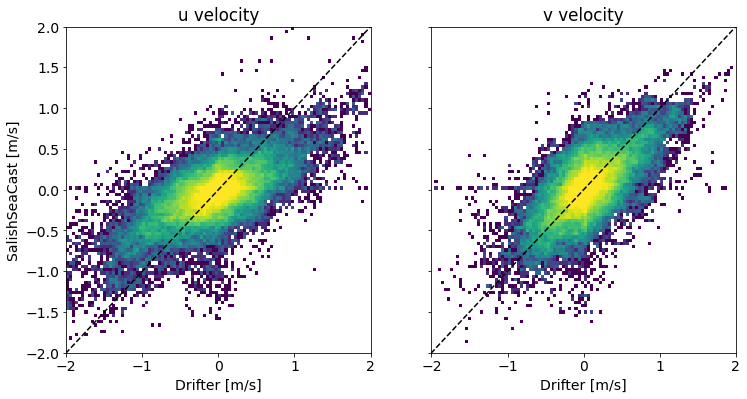

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
xlim, ylim = [-2, 2], [-2, 2]
for ax, var in zip(axs, ['u', 'v']):
    index = ~np.logical_or(*[np.isnan(velocities[key][var]) for key in ('obs', 'NEMO')])
    index = np.logical_and(index, np.logical_and(*[np.isfinite(velocities[key][var]) for key in ('obs', 'NEMO')]))
    ax.hist2d(*[velocities[key][var][index] for key in ('obs', 'NEMO')], bins=100, range=[xlim, ylim], norm=colors.LogNorm(vmin=1, vmax=200))
    ax.plot([-4, 4], [-4, 4], 'k--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Drifter [m/s]')
    if var == 'u': ax.set_ylabel('SalishSeaCast [m/s]')
    else: ax.yaxis.set_ticklabels('')
    ax.set_title(f'{var} velocity')